In [1]:
import sys; from pathlib import Path
src_dir = next(parent / 'src' for parent in Path().absolute().parents if (parent / 'src').is_dir())
sys.path.extend([str(src_dir), str(src_dir / 'pipelines')])
from imports import * ; current_dir = Path().resolve()
folder_outputs = create_output_folder(folder_name='Figures_Spatial_Model')
#folder_outputs = create_output_folder(folder_name='Figures_Exercise_Constitutive')
saving_data = True
loading_data = False
if saving_data == False:
    folder_simulated_data = current_dir.joinpath('simulated_data')
else:
    folder_simulated_data = create_output_folder(folder_name='simulated_data')


In [2]:
# Parameters
k_on = 0.5
k_off = 0.1
k_r = 3
k_p = 0.9 #0.9
gamma_r = 0.08 #0.05 # assuming gamma_rn = gamma_rc
gamma_p = 0.45  # 0.65
transport_rate = 1 # fixing the transport rate for this model
diffusion_rate = 10 # assuming diffusion_rate_r = diffusion_rate_p
total_simulation_time = 200
number_of_simulated_cells = 200 #number_cpus
cytosol_diameter = 110
nucleus_diameter = 60
model_type = '2D'
# simulating inhibition 
apply_drug =True
drug_application_time = 120
inhibition_constant = 0.1
inhibited_parameters={'transport_rate': transport_rate*inhibition_constant}
position_TS= 'random' #'center' # position of the transcription site
# Parameters for plotting
max_y_val =65
# adding burnin time to allow the system to reach steady state
burnin_time = 0
protein_scaling_factor =2.5
list_times_image = np.linspace(5, total_simulation_time, 6).astype(int)
time_points = list_times_image


In [3]:
np.linspace(5, total_simulation_time, 6).astype(int)

array([  5,  44,  83, 122, 161, 200])

In [4]:
# Example of setting up and running the simulation
if model_type == '2D':
        number_dimension =2
else:   
        number_dimension =3
params = {
        'k_on': k_on, 
        'k_off': k_off,
        'k_r': k_r, 
        'gamma_r': gamma_r,
        'k_p': k_p,
        'gamma_p': gamma_p,
        'k_diff_r': diffusion_rate, 
        'k_diff_p': diffusion_rate,
        'transport_rate':transport_rate,
        'nucleus_size': [nucleus_diameter]*number_dimension,  # Assuming spherical shapes for simplicity. Diameter
        'cytosol_size': [cytosol_diameter]*number_dimension,  # Assuming spherical shapes for simplicity . Diameter
        'total_time': total_simulation_time,
        'simulation_volume_size': [cytosol_diameter+30]*number_dimension, # 3D simulation size
        'simulation_type': model_type, # options are '2D' or '3D'
        'frame_rate' : 1,
        'movement_protein_into_nucleus' : False,  # Allow protein movement in nucleus
        'position_TS':position_TS, # options are 'center' or 'random'
        'apply_drug': apply_drug,
        'drug_application_time': drug_application_time,
        'inhibited_parameters':inhibited_parameters,
        'burnin_time': burnin_time,
}

In [5]:
if loading_data == False:
    params_list = [(params, i) for i in range(number_of_simulated_cells)]
    with Pool() as pool:
        results_list = pool.map(simulate_gene_expression, params_list)
    time_steps, RNA_nucleus_counts, RNA_cytosol_counts, total_Protein_counts = zip(*[get_counts(trajectories=result) for result in results_list])
    time_steps = time_steps[0] # as time steps is same for all simulations
    # Convert lists of counts to numpy arrays
    array_RNA_nucleus = np.array(RNA_nucleus_counts)
    array_RNA_cytosol = np.array(RNA_cytosol_counts)
    array_total_Protein = np.array(total_Protein_counts)

In [6]:
if saving_data:
    # saving simulated data in simulated_data folder
    np.save(folder_simulated_data.joinpath('time_steps.npy'), time_steps)
    np.save(folder_simulated_data.joinpath('array_total_Protein.npy'), array_total_Protein)
    np.save(folder_simulated_data.joinpath('array_RNA_nucleus.npy'), array_RNA_nucleus)
    np.save(folder_simulated_data.joinpath('array_RNA_cytosol.npy'), array_RNA_cytosol)
if loading_data:
    # loading simulated data from simulated_data folder
    time_steps = np.load(folder_simulated_data.joinpath('time_steps.npy'))
    array_total_Protein = np.load(folder_simulated_data.joinpath('array_total_Protein.npy'))
    array_RNA_nucleus = np.load(folder_simulated_data.joinpath('array_RNA_nucleus.npy'))
    array_RNA_cytosol = np.load(folder_simulated_data.joinpath('array_RNA_cytosol.npy'))

In [7]:
# Plotting the mean trajectory for each species
mean_RNA_nucleus = np.mean(array_RNA_nucleus, axis=0)
mean_RNA_cytosol = np.mean(array_RNA_cytosol, axis=0)
mean_total_Protein = np.mean(array_total_Protein, axis=0)
# calculating the std
std_RNA_nucleus = np.std(array_RNA_nucleus, axis=0)
std_RNA_cytosol = np.std(array_RNA_cytosol, axis=0)
std_total_Protein = np.std(array_total_Protein, axis=0)

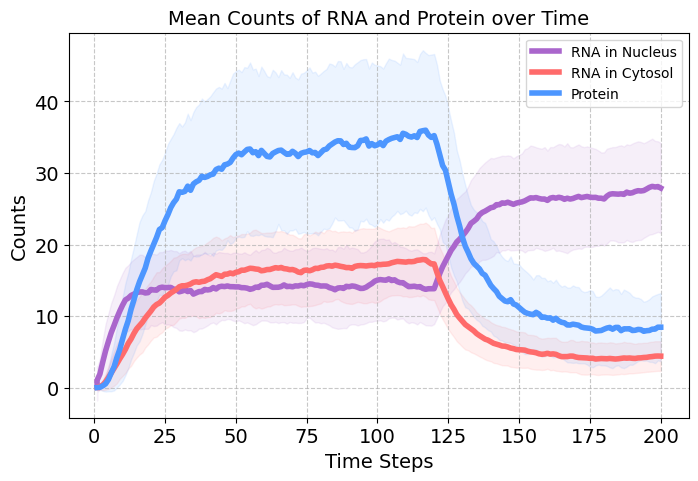

In [8]:
plot_time_courses_simulation(time_steps,mean_RNA_nucleus,mean_RNA_cytosol, mean_total_Protein, std_RNA_nucleus, std_RNA_cytosol, std_total_Protein,species_colors, drug_application_time=None, max_y_val=None,folder_outputs=folder_outputs)

In [9]:
array_RNA_nucleus.shape

(200, 201)

In [10]:
if saving_data:
    # saving simulated data in simulated_data folder
    np.save(folder_simulated_data.joinpath('time_points_snapshots.npy'), time_points)
    np.save(folder_simulated_data.joinpath('snapshots_total_Protein_.npy'), array_total_Protein[:,time_points])
    np.save(folder_simulated_data.joinpath('snapshots_RNA_nucleus.npy'), array_RNA_nucleus[:,time_points])
    np.save(folder_simulated_data.joinpath('snapshots_RNA_cytosol.npy'), array_RNA_cytosol[:,time_points])

## This section of the code simulates the Spatio-Temporal model. It takes the mechanistic model simulation and simulates the 2D spatial model.

____

In [11]:
array_protein_intensity_cytosol_image = np.zeros( (number_of_simulated_cells,len(list_times_image)))
array_rna_nucleus_image = np.zeros((number_of_simulated_cells,len(list_times_image)))
array_rna_cytosol_image = np.zeros((number_of_simulated_cells,len(list_times_image)))
# Initialize the lists to store particles
particles_in_nucleus_list_all_cells = [[] for _ in range(number_of_simulated_cells)]
particles_in_cytosol_list_all_cells = [[] for _ in range(number_of_simulated_cells)]
list_masks_nucleus = []
list_masks_cytosol = []
list_simulated_images = []
for cell in range(number_of_simulated_cells):
    results = results_list[cell]
    simulated_image = simulate_cell_2d (trajectories = results,list_times = list_times_image, simulation_volume_size = params['simulation_volume_size'],mask_cytosol = results['cytosol_mask'],mask_nucleus = results['nucleus_mask'],protein_scaling_factor=protein_scaling_factor)
    list_simulated_images.append(simulated_image)
    for i, time_point in enumerate(list_times_image):
        simulated_image_RNA_segmentation = simulated_image[i,:,:,0] # for segmentation we will use the RNA channel and the first time point.
        simulated_image_RNA = simulated_image[i,:,:,0] 
        simulated_image_protein = simulated_image[i,:,:,1]
        nucleus_mask_segmented, cytosol_mask_segmented = cell_segmentation(image = simulated_image_RNA_segmentation) # for segmentation we will use the RNA channel and the first time point.
        particles_in_nucleus, particles_in_cytosol = detect_particles(simulated_image_RNA,nucleus_mask_segmented,cytosol_mask_segmented,diameter=5, minmass=20)
        
        #particles_in_nucleus, particles_in_cytosol = detect_particles(simulated_image_RNA,nucleus_mask_segmented,cytosol_mask_segmented,diameter=5, minmass=20)
        #protein_mean_intensity_cytosol = protein_intensity_quantification(simulated_image_protein, cytosol_mask_segmented)
        protein_in_nucleus,protein_in_cytosol = detect_particles(simulated_image_protein,nucleus_mask_segmented,cytosol_mask_segmented,diameter=5, minmass=20)

        array_protein_intensity_cytosol_image[cell,i] = len(protein_in_cytosol)+ len(protein_in_nucleus)
        array_rna_nucleus_image[cell,i] = len(particles_in_nucleus)
        array_rna_cytosol_image[cell,i] = len(particles_in_cytosol)
        particles_in_nucleus_list_all_cells[cell].append(particles_in_nucleus)
        particles_in_cytosol_list_all_cells[cell].append(particles_in_cytosol)
    list_masks_nucleus.append(nucleus_mask_segmented)
    list_masks_cytosol.append(cytosol_mask_segmented)


In [12]:
# Plotting the mean trajectory for each species
mean_RNA_nucleus_image = np.mean(array_rna_nucleus_image, axis=0)
mean_RNA_cytosol_image = np.mean(array_rna_cytosol_image, axis=0)
mean_total_Protein_image = np.mean(array_protein_intensity_cytosol_image, axis=0)
# calculating the std
std_RNA_nucleus_image = np.std(array_rna_nucleus_image, axis=0)
std_RNA_cytosol_image = np.std(array_rna_cytosol_image, axis=0)
std_total_Protein_image = np.std(array_protein_intensity_cytosol_image, axis=0)

In [13]:
if saving_data:
    # saving simulated data in simulated_data folder
    np.save(folder_simulated_data.joinpath('time_points_snapshots_image.npy'), list_times_image)
    np.save(folder_simulated_data.joinpath('snapshots_total_Protein_image.npy'), array_protein_intensity_cytosol_image)
    np.save(folder_simulated_data.joinpath('snapshots_RNA_nucleus_image.npy'), array_rna_nucleus_image)
    np.save(folder_simulated_data.joinpath('snapshots_RNA_cytosol_image.npy'), array_rna_cytosol_image)

In [14]:
array_rna_cytosol_image.shape

(200, 6)

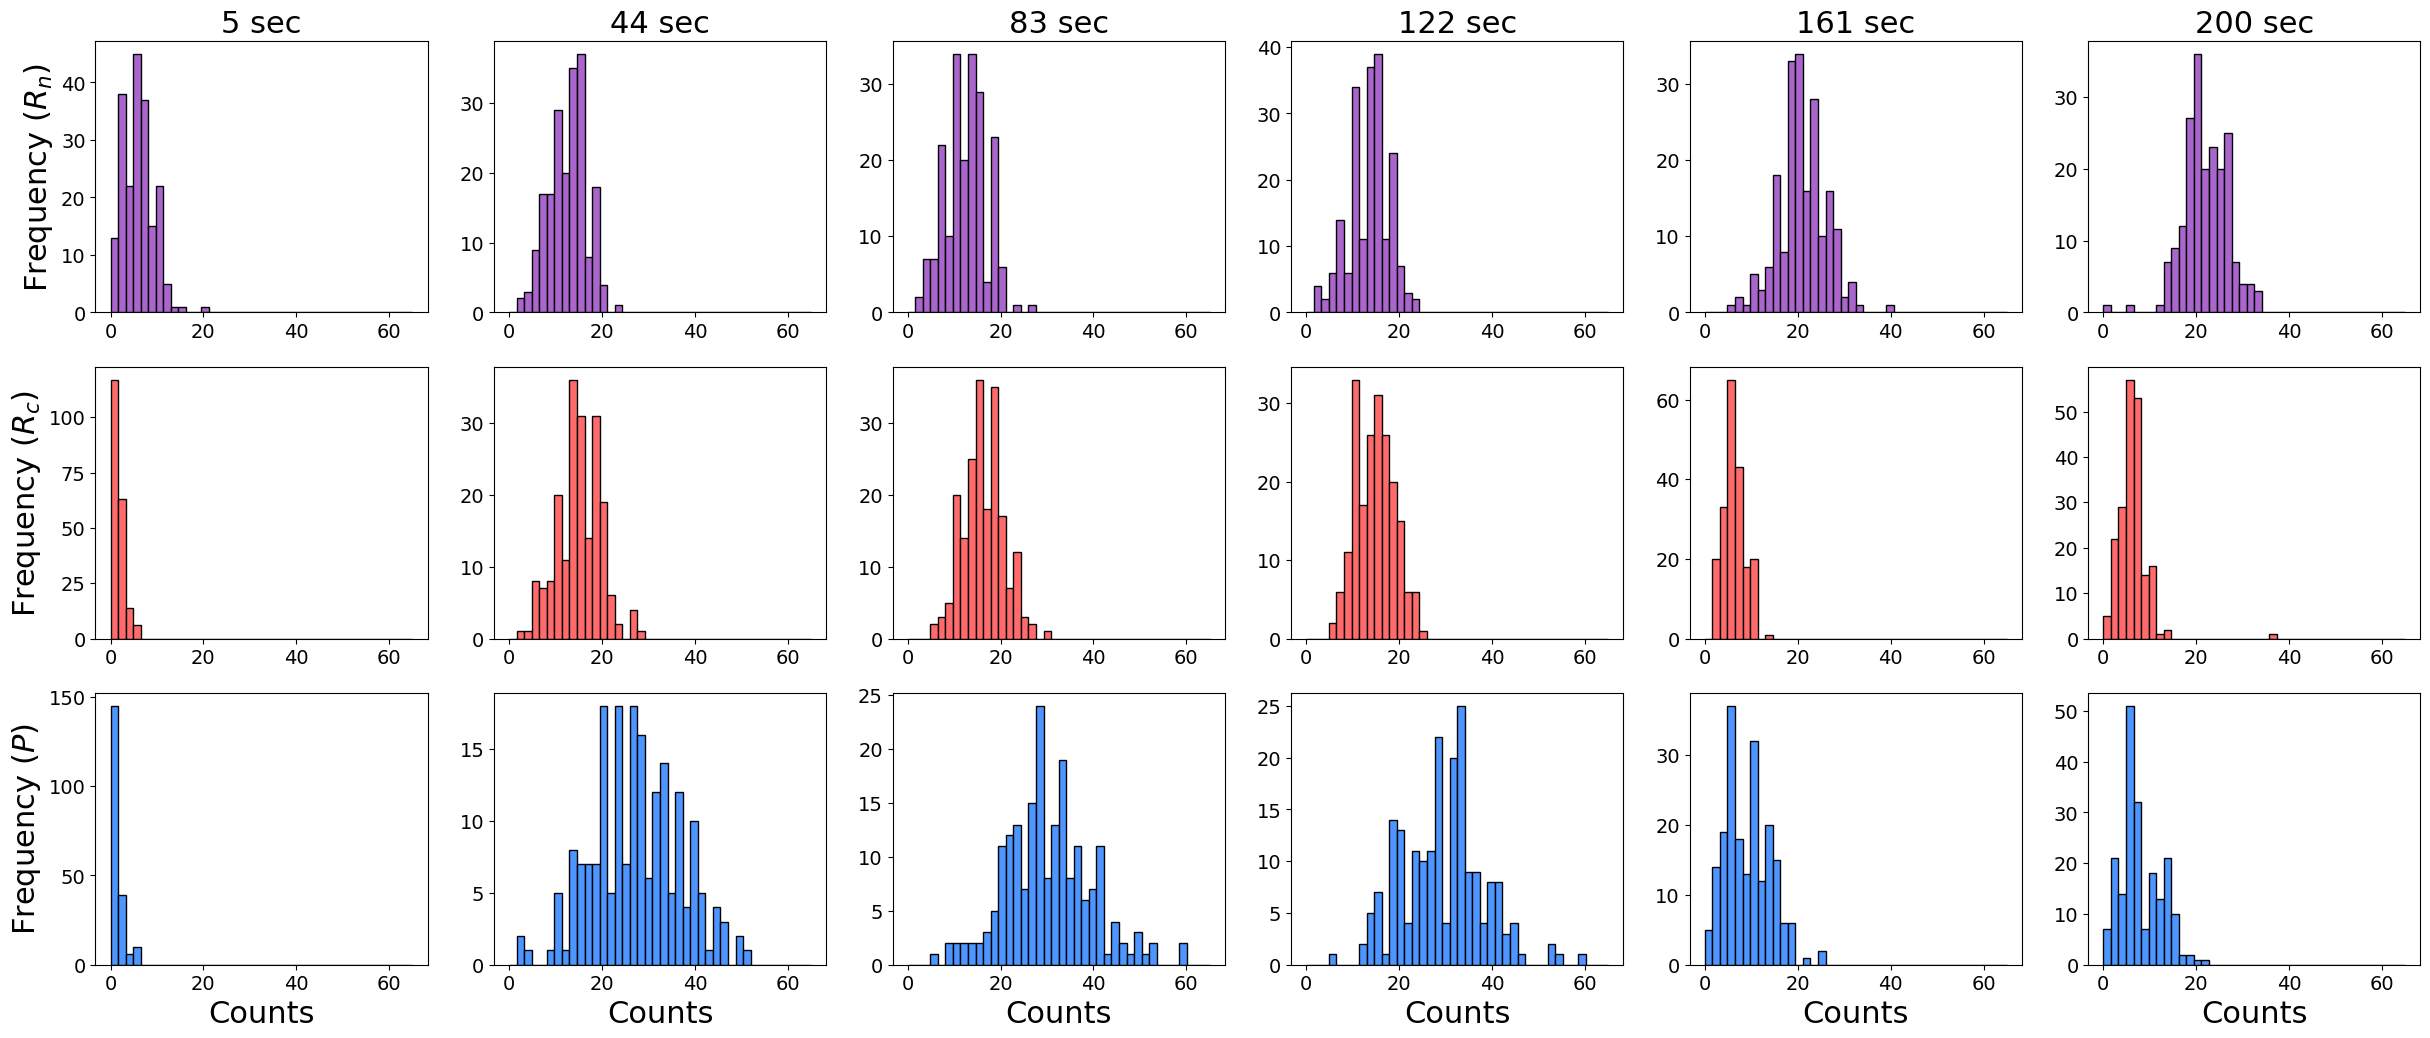

In [15]:
#time_points = np.array([5,10,20,40,60,80,100,130,150,200]).astype(int)
plot_distribution([array_rna_nucleus_image,array_rna_cytosol_image,array_protein_intensity_cytosol_image],
                  time_points=list_times_image, bin_min=0, bin_max=65, n_bins=40, 
                  list_colors=[species_colors['R_n'] , species_colors['R_c'], species_colors['P']],
                  super_titles=['mRNA in Nucleus', 'mRNA in Cytosol', 'Protein'],
                  drug_application_time=drug_application_time,folder_outputs=folder_outputs)

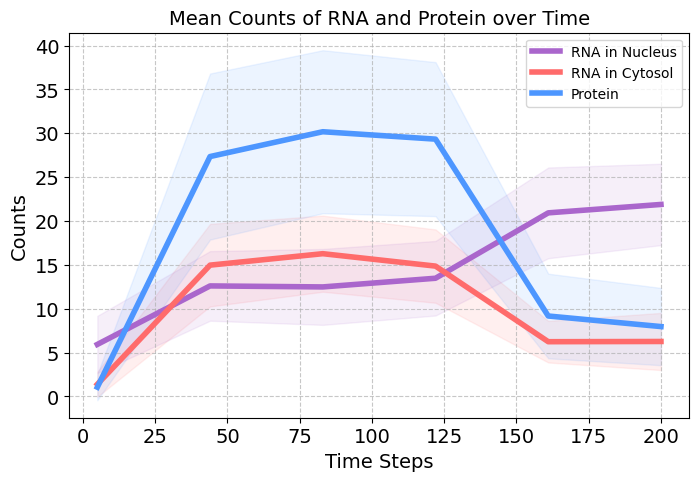

In [16]:
plot_time_courses_simulation(list_times_image,mean_RNA_nucleus_image,mean_RNA_cytosol_image, mean_total_Protein_image, std_RNA_nucleus_image, std_RNA_cytosol_image, std_total_Protein_image,species_colors=species_colors, drug_application_time=None, max_y_val=None)

# Plotting a selected cell for visualization. 

____

In [18]:
selected_cell = 1
selected_time_point = 5
simulated_image = list_simulated_images[selected_cell]
simulated_image_RNA = list_simulated_images[selected_cell][:,:,:,0] 
simulated_image_protein = list_simulated_images[selected_cell][:,:,:,1]
particles_in_nucleus_list = particles_in_nucleus_list_all_cells[selected_cell]
particles_in_cytosol_list = particles_in_cytosol_list_all_cells[selected_cell]
particles_in_nucleus = particles_in_nucleus_list_all_cells[selected_cell][selected_time_point]
particles_in_cytosol = particles_in_cytosol_list_all_cells[selected_cell][selected_time_point]
nucleus_mask_segmented = list_masks_nucleus[selected_cell]
cytosol_mask_segmented = list_masks_cytosol[selected_cell]


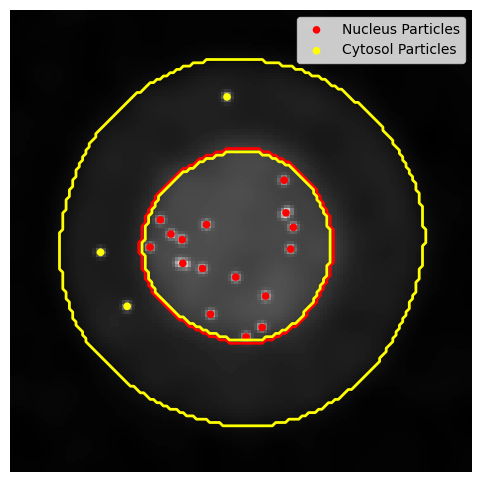

In [19]:
# Combined Plot of Particles and Masks
plt.figure(figsize=(6, 6))
plt.imshow(simulated_image[selected_time_point,:,:,0], cmap='gray')
plt.axis('off')
plt.scatter(particles_in_nucleus['x'], particles_in_nucleus['y'], c='red', s=30, label='Nucleus Particles', edgecolors='none')
plt.scatter(particles_in_cytosol['x'], particles_in_cytosol['y'], c='yellow', s=30, label='Cytosol Particles', edgecolors='none')
plt.contour(nucleus_mask_segmented, levels=[0.5], colors='red', linewidths=2, linestyles='solid')
plt.contour(cytosol_mask_segmented, levels=[0.5], colors='yellow', linewidths=2, linestyles='solid')
plt.legend(loc='upper right')
plt.show()


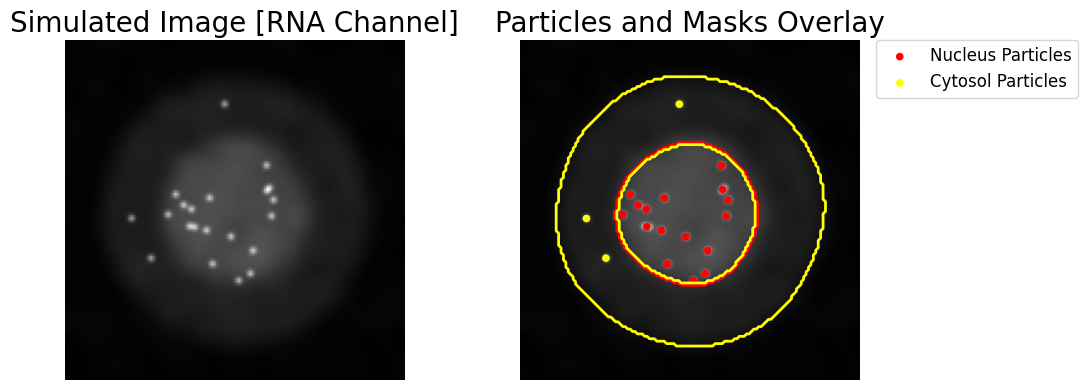

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(simulated_image_RNA[selected_time_point], cmap='gray') 
axs[0].axis('off')
axs[0].set_title('Simulated Image [RNA Channel]', fontsize=20)
axs[1].imshow(simulated_image_RNA[selected_time_point], cmap='gray'); 
axs[1].axis('off')
axs[1].set_title('Particles and Masks Overlay', fontsize=20)
axs[1].scatter(particles_in_nucleus['x'], particles_in_nucleus['y'], c='red', s=30, label='Nucleus Particles', edgecolors='none')
axs[1].scatter(particles_in_cytosol['x'], particles_in_cytosol['y'], c='yellow', s=30, label='Cytosol Particles', edgecolors='none')
axs[1].contour(nucleus_mask_segmented, levels=[0.5], colors='red', linewidths=2)
axs[1].contour(cytosol_mask_segmented, levels=[0.5], colors='yellow', linewidths=2)
#axs[1].legend(loc='upper left', fontsize=16)
axs[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=12)

plt.tight_layout()
plt.savefig(folder_outputs.joinpath('segmentation_spot_detection.png'), dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)
plt.show()


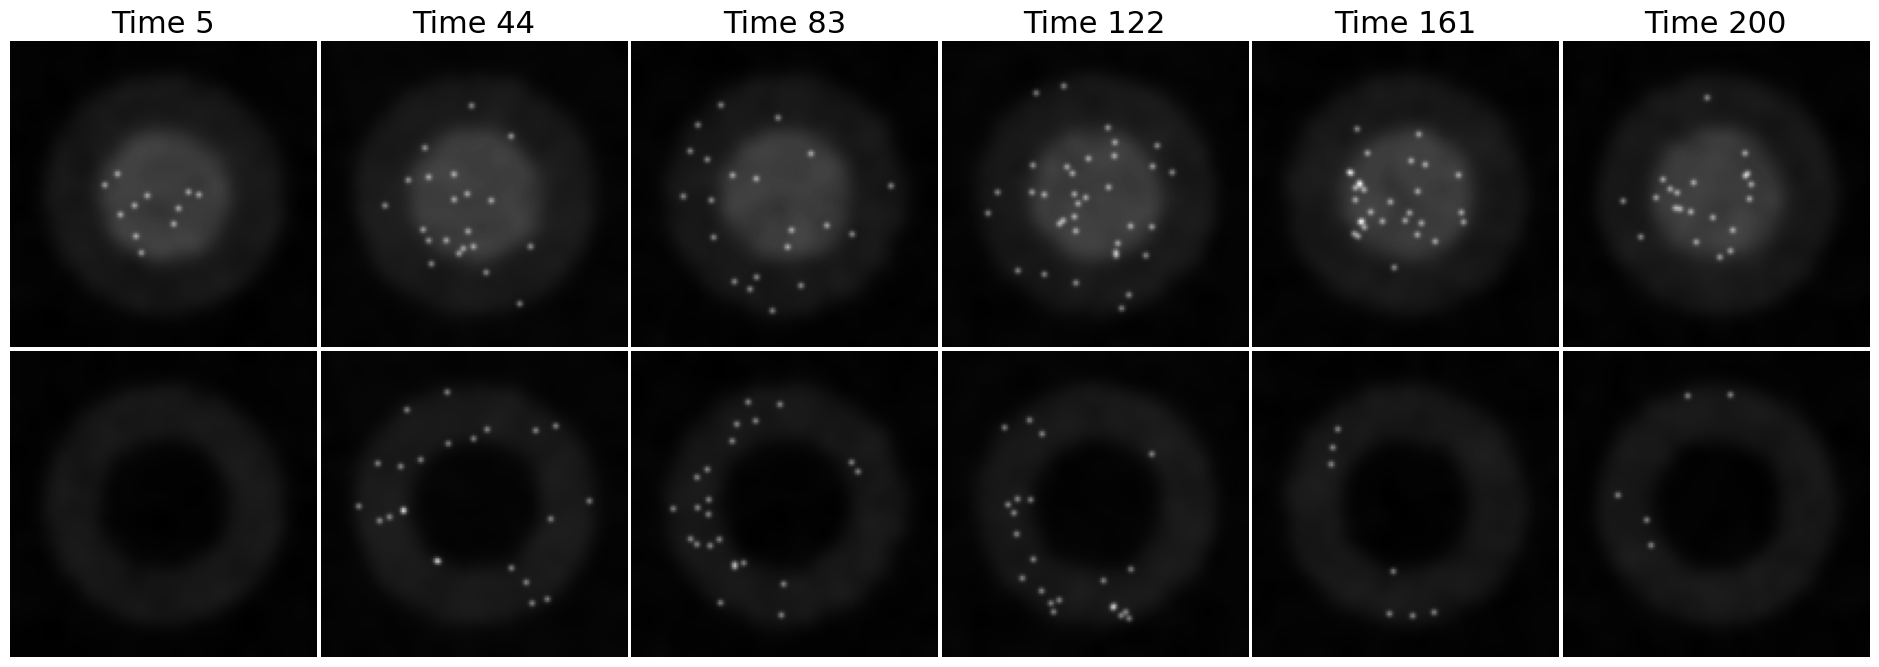

In [21]:
plot_simulation_results(simulated_image, list_times_image, cytosol_mask_segmented, nucleus_mask_segmented, particles_in_nucleus_list, particles_in_cytosol_list, plot_detection=False,
                        save_figure=True,folder_outputs=folder_outputs,plot_name='simulation_spatial_model.png')


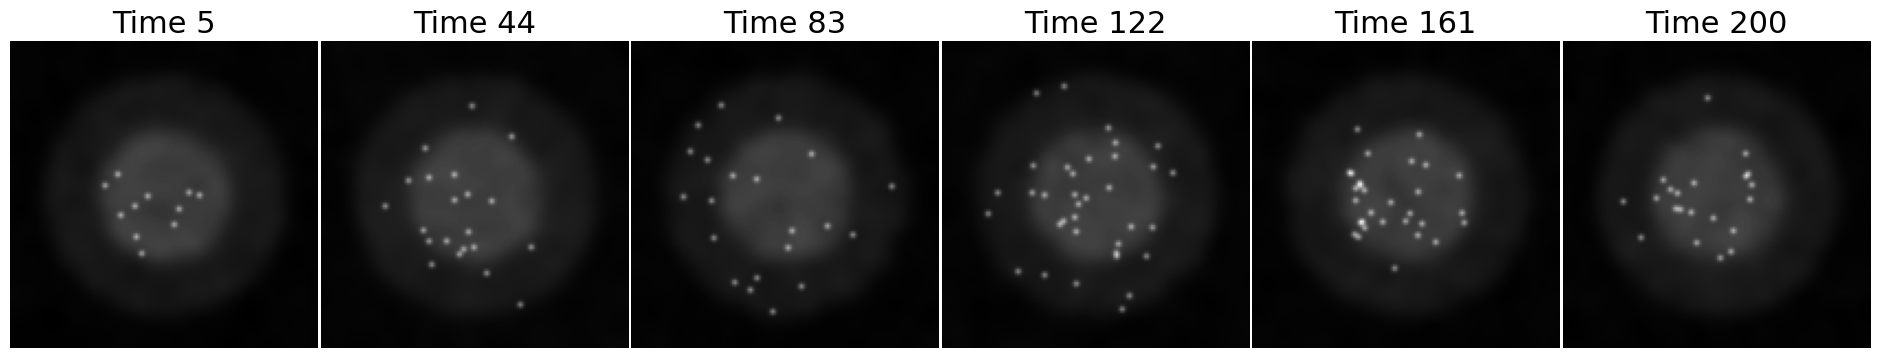

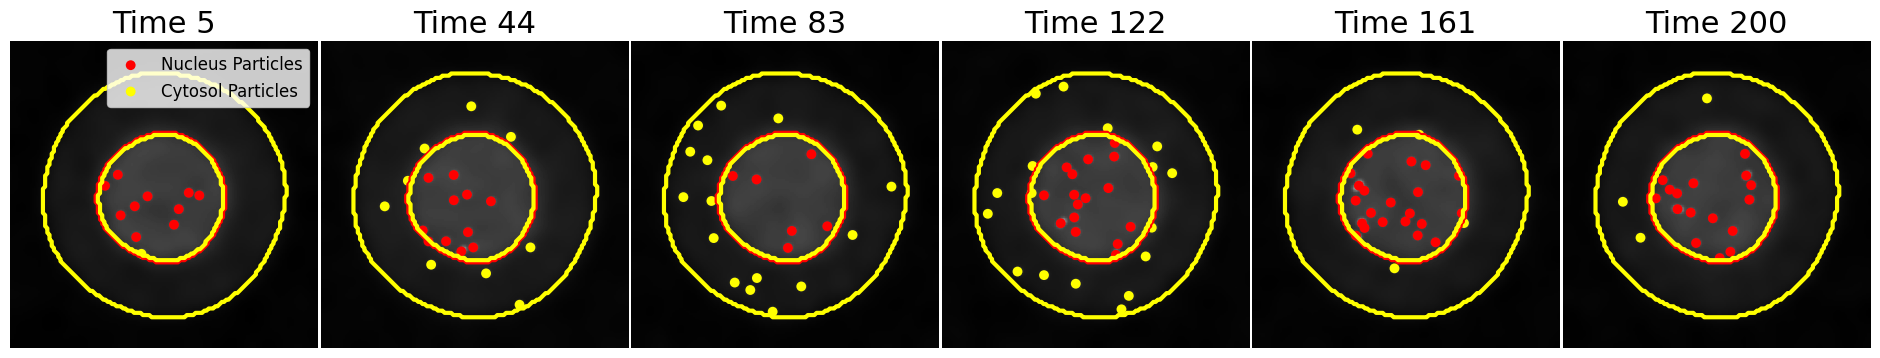

In [22]:
plot_simulation_results(simulated_image, list_times_image, cytosol_mask_segmented, nucleus_mask_segmented, particles_in_nucleus_list, particles_in_cytosol_list, plot_detection=False, channels_to_plot='RNA')
plot_simulation_results(simulated_image, list_times_image, cytosol_mask_segmented, nucleus_mask_segmented, particles_in_nucleus_list, particles_in_cytosol_list, plot_detection=True, channels_to_plot='RNA')
